In [1]:
import matplotlib.pyplot as plt
import os,glob
import numpy as np
import seaborn as sns
from scipy.special import kn,zetac
import copy
import mypyslha as pyslha
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
sns.set_palette(sns.color_palette("Paired"))

In [2]:
def getContour(xpts,ypts,zpts,levels):
    """
    Uses pyplot tricontour method to obtain contour
    curves in a 2D plane.

    :return: A dictionary with a list of contours for each level
    """
    
    fig = plt.figure()
    x = copy.deepcopy(xpts)
    y = copy.deepcopy(ypts)
    z = copy.deepcopy(zpts)
    CS = plt.tricontour(x,y,z,levels=levels)    
    levelPts = {}
    for il,level in enumerate(CS.levels):
        levelPts[level] = []
        c = CS.collections[il]        
        paths = c.get_paths()
        for path in paths:
            levelPts[level].append(path.vertices)
    plt.close(fig)
    
    return levelPts

## Get CheckMate Output

In [3]:
rValues = []
allAna = []
bestAna = []
for fname in glob.glob('../data/checkmate/*'):
    slhafile = os.path.basename(fname)+'.slha'
    checkmateFile = os.path.join(fname,'result.txt')
    slhadata = pyslha.readSLHAFile(os.path.join('../data/slha_BM1/',slhafile))
    with open(checkmateFile,'r') as f:
        r = f.read().split('Result for r:')[1].splitlines()[0]
    r = eval(r)
    mDM = slhadata.blocks['MASS'][5000522]
    mChi1 = slhadata.blocks['MASS'][5000521]
    rValues.append([mChi1,mChi1-mDM,r])

In [4]:
rValues = np.array(rValues)

In [5]:
kfactor = 1.5
excCurve = np.array(getContour(rValues[:,0],rValues[:,1],kfactor*rValues[:,2],levels=[1.])[1.][0])
excCurve[:,1] = excCurve[:,1]
# excCurve = np.append(excCurve,[excCurve[0]],axis=0) #Make sure curve closes

## Plot Curves

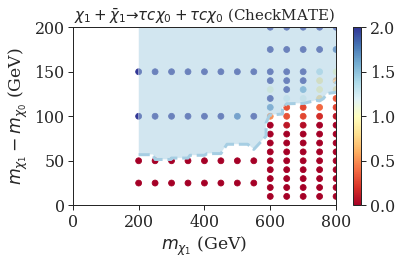

In [8]:
cp = plt.scatter(rValues[:,0],rValues[:,1],c=rValues[:,2],s=35,cmap=plt.cm.get_cmap('RdYlBu'), vmin=0., vmax=2.)
plt.plot(excCurve[:,0],excCurve[:,1],label='Exclusion',linewidth=3,linestyle='--')
plt.fill_between(excCurve[:,0],excCurve[:,1],excCurve[:,1].max(),alpha=0.5)
cb = plt.colorbar(cp)
# plt.yscale('log')
plt.xlabel(r'$m_{\chi_1}$ (GeV)')    
plt.ylabel(r'$m_{\chi_1}-m_{\chi_0}$ (GeV)')
plt.xlim(0.,800.)
plt.ylim(0,200.)
# plt.legend()
plt.tight_layout()
plt.title(r"$\chi_1 + \bar{\chi}_1 \to \tau c \chi_0 + \tau c \chi_0$ (CheckMATE)",fontsize=15)
plt.tight_layout()
plt.savefig('TStauStau_exclusion_BM1.png')
plt.show()

In [16]:
np.savetxt('TStauStau_exclusion_BM1.txt',excCurve,delimiter=',',header="mchi1 (GeV), mchi1-mchi0 (GeV)")